In [24]:
import json
import uuid
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import ranksums, kstest
from scipy.stats import wasserstein_distance

from openai import OpenAI
from matplotlib.ticker import FuncFormatter

## Utils

### OpenAI

In [ ]:
client = OpenAI(api_key="YOUR_API_KEY")

### Plotting

In [4]:
sns.set(rc={'figure.figsize':(5,4)})
sns.set_style("ticks")

default_palette = sns.color_palette(None)
blue = default_palette[0]
orange = default_palette[1]
green = default_palette[2]
red = default_palette[3]
purple = default_palette[4]

In [5]:
def choices_to_df(choices, hue):
    df = pd.DataFrame(choices, columns=['choices'])
    df['hue'] = hue
    df['hue'] = df['hue'].astype(str)
    return df

In [6]:
def plot_facet(
    df_list,
    x='choices',
    hue='hue',
    palette=None,
    binrange=None,
    bins=10,
    # binwidth=10,
    stat='density',
    x_label='',
    title='',
    sharex=True,
    sharey=False,
    subplot=sns.histplot,
    xticks_locs=None,
    # kde=False,
    **kwargs
):
    data = pd.concat(df_list)
    if binrange is None:
        binrange = (data[x].min(), data[x].max())
    g = sns.FacetGrid(
        data, row=hue, hue=hue, 
        palette=palette,
        aspect=2, height=2, 
        sharex=sharex, sharey=sharey,
        despine=True,
    )
    g.map_dataframe(
        subplot, 
        x=x, 
        # kde=kde, 
        binrange=binrange, 
        bins=bins,
        stat=stat,
        **kwargs
    )
    # g.add_legend(title='hue')
    g.set_axis_labels(x_label, stat.title())
    g.set_titles(row_template="")
    g.fig.suptitle(title)
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(
            FuncFormatter(lambda y, pos: '{:.2f}'.format(y))
        )
    
    binwidth = (binrange[1] - binrange[0]) / bins
    if xticks_locs is None:
        locs = np.linspace(binrange[0], binrange[1], bins//2+1)
        locs = [loc + binwidth for loc in locs]
    else: 
        locs = xticks_locs
    labels = [str(int(loc)) for loc in locs]
    locs = [loc + 0.5*binwidth for loc in locs]
    plt.xticks(locs, labels)
    
    g.set(xlim=binrange)
    return g

### Game Instructions

In [7]:
game2inst = {
    'Dictator': "You are paired with another player. Your role is to decide how to divide $100 and the other player simply receives your choice. How would you like to divide the money? Please give only one concrete choice and highlight the amount you give to the other player in [] (such as [$x]).",
    'Proposer': "This is a two-player game. You are the Proposer, and the other player is the Responder. As the proposer, you propose how to divide $100 and the Responder chooses either Accept or Reject. If accepted, the two of you will earn as described by the accepted proposal accordingly. If rejected, then both of you will earn $0. \nHow much would you like to propose to give to the Responder? Please give only one concrete choice, and highlight the amount with [] (such as [$x]).",
    'Responder': "This is a two-player game. You are the Responder, and the other player is the Proposer. The proposer proposes how to divide $100 and you, as the Responder, choose either Accept or Reject. If accepted, the two of you will earn as described by the accepted proposal accordingly. If rejected, then both of you will earn $0. \nAs the Responder, what is the minimal amount in the proposal that you would accept? Please give only one concrete choice, and highlight the amount with [] (such as [$x]).",
    'Investor': "This is a two-player game. You are an Investor and the other player is a Banker. You have $100 to invest and you choose how much of your money to invest with the Banker. The amount you choose to invest will grow by 3x with the Banker. For example, if you invest $10, it will grow to $30 with the Banker. The Banker then decides how much of the money ($0-$30) to return to you, the Investor.\nHow much of the $100 would you like to invest with the Banker? Please give only one concrete choice, and highlight the number with [] (such as [$x]).",
    'Banker': "This is a two-player game. You are a Banker and the other player is an Investor, and the goal for each player is to earn more. The Investor chooses how much of the money (up to $100) to invest with you. The amount the Investor invests will generate a 2x return with you (the current value of investment becomes 3x).  To settle the investment, as the Banker, you get to decide how much of this total amount to return to the Investor and the rest will be kept as your profit.  For example, you can choose to return $0 (therefore the investor will lose their investment), or you can return the entire 3x (initial investment + 2x profit) to the investor, or you can return any amount in between.\nNow, if the investor has invested $50 with you and the current value became $150, how much of the $150 would you like to return to the Investor? Please give only one concrete choice, and highlight the number with [] (such as [$x]).",
    'Public Goods': "In this public good game, you and 3 others will choose how much to contribute towards a water cleaning project. Each of you gets $20 per round to contribute between $0 and $20. The project has a 50% return rate. Your payoff relies on both your and others' contributions. Everyone benefits from the group's total contribution. Your payoff in each round equals the amount you didn't contribute (endowment - contribution) plus everyone's benefit (total contributions * 50% return rate). Here are two examples to calculate your payoff.\n\nExample one: You contributed $12; total group contributions were $20\n\nYour Payoff = ($20-$12) + $20*50% = $18\n\nExample two: You contributed $12; total group contributions were $30\n\nYour Payoff = ($20-$12) + $30*50% = $23\n\nWe will play a total of 3 rounds, in the first round, how much of the $20 would you like to contribute? Please give a concrete number and highlight it with [] (e.g., [x]).",
    'Bomb': "There are 100 boxes, and one bomb has been randomly placed in 1 of 100 boxes. You can choose to open 0-100 boxes at the same time. If none of the boxes you open has the bomb, you earn points that are equal to the number of boxes you open. If one of the boxes you open has the bomb, you earn zero points.  How many boxes would you open? Please give one concrete number and highlight it with [] (such as [x]).",
}

In [8]:
game2range = {
    'Dictator': (0, 100),
    'Proposer': (0, 100),
    'Responder': (0, 100),
    'Investor': (0, 100),
    'Banker': (0, 150),
    'Public Goods': (0, 20),
    'Bomb': (0, 100),
}

### Game Play

In [9]:
def play(
        game, 
        system_prompt="You are a helpful assistant.", 
        n_choices=1
    ):
    
    completion = client.chat.completions.create(
        model='gpt-4o-2024-05-13',
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": game2inst[game]}
        ],
        n=n_choices,
    )

    responses = [choice.message.content for choice in completion.choices]
    choices = []
    completions = []

    for response in responses:
        while True:
            completion = client.chat.completions.create(
                model='gpt-4o-mini-2024-07-18',
                messages=[
                    {"role": "system", "content": "You are a helpful assistant who helps extract the choice in a conversation. With a conversation between a user and a chatbot provided, please extract the chatbot's choice regarding the user's question. "},
                    {"role": "user", "content": game2inst[game]},
                    {"role": "assistant", "content": response},
                    {"role": "user", "content": "Please output one single integer number that stands for the choice without anything else:"}
                ],
            )
            try:
                choice = completion.choices[0].message.content
                choice = ''.join(filter(str.isdigit, choice))
                choice = int(choice)
                choices.append(choice)
                completions.append(completion.to_dict())
                break
            except:
                pass

    return choices, completions

## Load Human Data

In [10]:
df_joint = pd.read_csv('data/MobLab/joint.csv')
df_joint.rename(columns={
    'dictator': 'Dictator',
    'ultimatum_1': 'Proposer',
    'ultimatum_2': 'Responder',
    'trust_1': 'Investor',
    'trust_3': 'Banker',
    'bomb': 'Bomb',
    'PG': 'Public Goods',
}, inplace=True)
df_joint

,UserID,Dictator,Proposer,Responder,Investor,Banker,Public Goods,Bomb
0,131074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,131075,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131078,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,131079,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,131080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
68774,131064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68775,262137,NaN,NaN,NaN,NaN,NaN,3.0,NaN
68776,393211,NaN,NaN,NaN,NaN,NaN,NaN,51.0
68777,131068,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Evaluate Function

In [11]:
def evaluate(
    game2generated, 
    human_data=df_joint,
    game2generated_cmp=None,
    need_rescale=True,
    need_plot=True,
    smooth_bin_width=10,
    noise_var=None,
):
    for game in game2generated.keys():
        print(f"Plotting {game}")
        generated = game2generated[game]
        if noise_var is not None:
            generated = np.random.normal(generated, noise_var)
        if game2generated_cmp is not None:
            target = game2generated_cmp[game]
        else: 
            target = df_joint[game].dropna().values

        w = wasserstein_distance(target, generated)
        if need_rescale:
            w = w * 100 / game2range[game][1]
        r = ranksums(target, generated).pvalue
        k = kstest(target, generated).pvalue
        print(f'Wasserstein Distance (rescaled): {w:.2f}')
        print(f'Ranksums p-value: {r:.2f}')
        print(f'Kolmogorov-Smirnov p-value: {k:.2f}')

        if need_plot: 
            plot_facet(
                df_list=[
                    choices_to_df(target, 'Target'),
                    choices_to_df(generated, 'Generated'),
                ],
                x='choices',
                hue='hue',
                binrange=game2range[game],
                palette=[blue, green],
                # palette=[green, orange],
                title=f'{game}',
            )
            # plt.savefig(f'plots/histogram-{game}.pdf', bbox_inches='tight')
            plt.show()

        bin_width = smooth_bin_width if not game == 'Public Goods' else 2
        target = [int(bin_width * round(x/bin_width)) for x in target]
        generated = [int(bin_width * round(x/bin_width)) for x in generated]
        k = kstest(target, generated).pvalue
        print(f'Smoothed Kolmogorov-Smirnov p-value: {k:.2f}')

## Test

### Upper Bound (Human Samples)

In [12]:
import scipy

n_runs = 1000
for game in game2inst:
    # print(game)
    target = df_joint[game].dropna()
    ws = []
    rs = []
    ks = []
    for i in range(n_runs):
        sample = target.sample(n=1000, random_state=i)
        ws.append(wasserstein_distance(target, sample))
        rs.append(ranksums(target, sample).pvalue)
        ks.append(kstest(target, sample).pvalue)
    print(f'Game: {game}')
    print(f'Wasserstein Distance: {np.mean(ws):.2f} ± {np.std(ws):.2f}, {scipy.stats.sem(ws):.2f}')
    print(f'Kolmogorov-Smirnov: {np.mean(ks):.2f} ± {np.std(ks):.2f}, {scipy.stats.sem(ks):.2f}')
    # print(f'Ranksums: {np.mean(rs):.2f} ± {np.std(rs):.2f}, {scipy.stats.sem(rs):.2f}')
    # print(f'{np.mean(ws):.2f}\t{np.std(ws):.2f}\t{scipy.stats.sem(ws):.2f}\t{np.mean(rs):.2f}\t{np.std(rs):.2f}\t{scipy.stats.sem(rs):.2f}\t')
    # print(f'{np.mean(ws):.2f}\t{np.std(ws):.2f}\t{scipy.stats.sem(ws):.2f}\t{np.mean(rs):.2f}\t{np.std(rs):.2f}\t{scipy.stats.sem(rs):.2f}\t{np.mean(ks):.2f}\t{np.std(ks):.2f}\t{scipy.stats.sem(ks):.2f}\t')

Game: Dictator
Wasserstein Distance: 0.69 ± 0.32, 0.01
Kolmogorov-Smirnov: 0.70 ± 0.28, 0.01
Game: Proposer
Wasserstein Distance: 0.72 ± 0.27, 0.01
Kolmogorov-Smirnov: 0.78 ± 0.24, 0.01
Game: Responder
Wasserstein Distance: 0.70 ± 0.28, 0.01
Kolmogorov-Smirnov: 0.76 ± 0.26, 0.01
Game: Investor
Wasserstein Distance: 1.11 ± 0.57, 0.02
Kolmogorov-Smirnov: 0.63 ± 0.30, 0.01
Game: Banker
Wasserstein Distance: 0.85 ± 0.36, 0.01
Kolmogorov-Smirnov: 0.98 ± 0.06, 0.00
Game: Public Goods
Wasserstein Distance: 0.21 ± 0.09, 0.00
Kolmogorov-Smirnov: 0.70 ± 0.29, 0.01
Game: Bomb
Wasserstein Distance: 0.90 ± 0.36, 0.01
Kolmogorov-Smirnov: 0.63 ± 0.30, 0.01


### Default System Prompt

Skip the below cell if you want to examine the tested results (`records/default_system_prompt.json`). 

In [13]:
# game2generated = {}
# game2records = {}
# for game in game2inst.keys():
#     print(f"Playing {game}")
#     choices, completion = play(game=game, n_choices=100)
#     game2generated[game] = choices
#     game2records[game] = completion
#     print(f"Done playing {game}")

In [14]:
# json.dump([game2generated, game2records], open('records/default_system_prompt.json', 'w'))
game2generated, game2records = json.load(open('records/default_system_prompt.json'))

In [15]:
evaluate(game2generated, need_plot=False)

Plotting Dictator
Wasserstein Distance (rescaled): 25.58
Ranksums p-value: 0.00
Kolmogorov-Smirnov p-value: 0.00
Smoothed Kolmogorov-Smirnov p-value: 0.00
Plotting Proposer
Wasserstein Distance (rescaled): 11.35
Ranksums p-value: 0.00
Kolmogorov-Smirnov p-value: 0.00
Smoothed Kolmogorov-Smirnov p-value: 0.00
Plotting Responder
Wasserstein Distance (rescaled): 33.99
Ranksums p-value: 0.00
Kolmogorov-Smirnov p-value: 0.00
Smoothed Kolmogorov-Smirnov p-value: 0.00
Plotting Investor
Wasserstein Distance (rescaled): 28.23
Ranksums p-value: 0.00
Kolmogorov-Smirnov p-value: 0.00
Smoothed Kolmogorov-Smirnov p-value: 0.00
Plotting Banker
Wasserstein Distance (rescaled): 20.00
Ranksums p-value: 0.00
Kolmogorov-Smirnov p-value: 0.00
Smoothed Kolmogorov-Smirnov p-value: 0.00
Plotting Public Goods
Wasserstein Distance (rescaled): 25.49
Ranksums p-value: 0.12
Kolmogorov-Smirnov p-value: 0.00
Smoothed Kolmogorov-Smirnov p-value: 0.00
Plotting Bomb
Wasserstein Distance (rescaled): 16.62
Ranksums p-val

### Batch Test

In [16]:
def batch_item(
    id=None,
    messages=[],
    model="gpt-4o-2024-05-13",
):
    if id is None:
        id = uuid.uuid4()
    return {
        "custom_id": id,
        "method": "POST", 
        "url": "/v1/chat/completions",
        "body": {
            "model": model,
            "messages": messages,
        }
    }

In [17]:
def batch_test(
    batch_id,
    model_file,
    test_game,
    n_samples=1000,
):
    model_name = '_'.join(model_file.split('_')[1:]).split('.')[0]
    df = pd.read_csv(model_file)
    weights = df['weight'] / df['weight'].sum()
    weights = weights.values
    pool_prompts = df['prompt'].values
    system_prompts = np.random.choice(
        pool_prompts, 
        size=n_samples, 
        replace=True, 
        p=weights
    ).tolist()

    batch = []
    for i, system_prompt in enumerate(system_prompts):
        batch.append(batch_item(
            id=f'{batch_id}_{model_name}_{test_game}_{i}',
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": game2inst[test_game]}
            ],
            model="gpt-4o-2024-05-13",
        ))
    return batch

In [18]:
model_files = {
    'Dictator': 'records/system_prompts_Dictator_weights_20241119171506.csv',
    'Proposer': 'records/system_prompts_Proposer_weights_20241119171514.csv',
    'Responder': 'records/system_prompts_Responder_weights_20241119171519.csv',
    'Investor': 'records/system_prompts_Investor_weights_20241119171538.csv',
    'Banker': 'records/system_prompts_Banker_weights_20241119171541.csv',
    'Public Goods': 'records/system_prompts_Public Goods_weights_20241119171548.csv',
    'Bomb': 'records/system_prompts_Bomb_weights_20241119171614.csv',
}

#### Single Test

In [19]:
batch = []
batch_id = pd.Timestamp.now().strftime('%Y%m%d%H%M%S')
for game, model_file in model_files.items():
    # if game in ['Dictator', 'Banker', 'Bomb']: continue
    batch.extend(batch_test(
        batch_id=batch_id,
        model_file=model_file,
        test_game=game,
        n_samples=1000,
    ))
    # break
len(batch)

7000

#### Transfer Test

In [20]:
batch = []
batch_id = pd.Timestamp.now().strftime('%Y%m%d%H%M%S')
for model, model_file in model_files.items():
    for test_game in model_files.keys():
        if model == test_game: continue
        batch.extend(batch_test(
            batch_id=batch_id,
            model_file=model_file,
            test_game=test_game,
            n_samples=1000,
        ))
len(batch)

42000

In [21]:
# file_name = f'batch_test_{batch_id}.jsonl'
# with open(f'records/{file_name}', 'w') as f:
#     for item in batch:
#         f.write(json.dumps(item) + '\n')

#### Extract Choices

In [22]:
# Single Test
batch_input_file = 'records/batch_test_20241120183939.jsonl'
batch_output_file = 'records/batch_673e735ab27c81908c6cadef063ba789_output.jsonl'

# Transfer Test 
# batch_input_file = 'records/batch_test_20250612040751.jsonl'
# batch_output_file = 'records/batch_684a8b8559888190aefc348b9933ead5_output.jsonl'

batch = []
batch_input = [json.loads(line) for line in open(batch_input_file)]
batch_output = [json.loads(line) for line in open(batch_output_file)]
assert len(batch_input) == len(batch_output)
for input, output in zip(batch_input, batch_output):
    id = input['custom_id']
    input_messages = input['body']['messages']
    output_message = output['response']['body']['choices'][0]['message']['content']
    messages = [
        {"role": "system", "content": "You are a helpful assistant who helps extract the choice in a conversation. With a conversation between a user and a chatbot provided, please extract the chatbot's choice regarding the user's question. "},
        *input_messages[1:],
        {"role": "assistant", "content": output_message},
        {"role": "user", "content": "Please output one single integer number that stands for the choice without anything else:"}
    ]
    batch.append(batch_item(
        id=f'extract_{batch_output_file}_{id}',
        messages=messages,
        model='gpt-4o-mini-2024-07-18',
    ))

# file_name = f"batch_extract_{batch_input_file.split('/')[-1]}_{batch_output_file.split('/')[-1]}.jsonl"
# with open(f'records/{file_name}', 'w') as f:
#     for item in batch:
#         f.write(json.dumps(item) + '\n')

In [25]:
model2generated = defaultdict(lambda: defaultdict(list))

# Single Test
file_name = 'records/batch_673e3d90e9d88190844d9f639808689e_output.jsonl' 

# Transfer Test 
# file_name = 'records/batch_684b9c0211cc819092c63df98e799063_output.jsonl'

for line in open(file_name):
    item = json.loads(line)
    id = item['custom_id']
    game = id.split('_')[-2]
    model_name = '_'.join(id.split('.jsonl_')[-1].split('_')[1:-2])

    completion = item['response']['body']['choices'][0]
    choice = completion['message']['content']
    choice = ''.join(filter(str.isdigit, choice))
    choice = int(choice)
    model2generated[model_name][game].append(choice)

#### Evaluate

68779
======= Evaluating model prompts_Dictator_weights_20241119171506...
Plotting Dictator
Wasserstein Distance (rescaled): 0.74
Ranksums p-value: 0.79
Kolmogorov-Smirnov p-value: 0.06


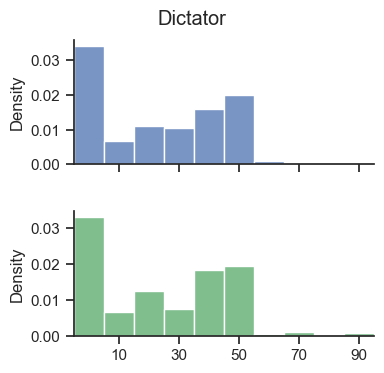

Smoothed Kolmogorov-Smirnov p-value: 0.78
======= Evaluating model prompts_Proposer_weights_20241119171514...
Plotting Proposer
Wasserstein Distance (rescaled): 0.92
Ranksums p-value: 0.49
Kolmogorov-Smirnov p-value: 0.14


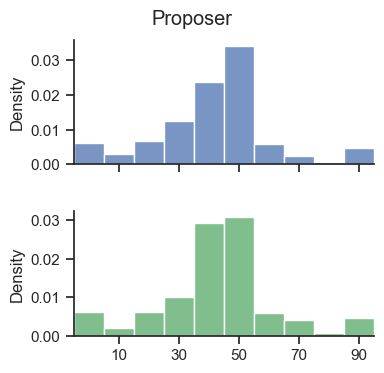

Smoothed Kolmogorov-Smirnov p-value: 0.30
======= Evaluating model prompts_Responder_weights_20241119171519...
Plotting Responder
Wasserstein Distance (rescaled): 1.11
Ranksums p-value: 0.20
Kolmogorov-Smirnov p-value: 0.00


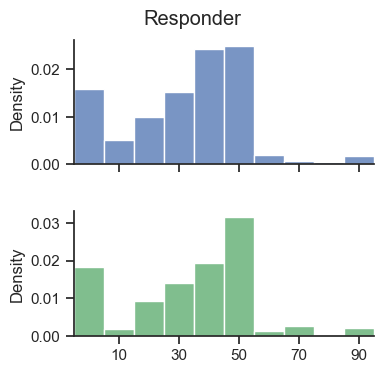

Smoothed Kolmogorov-Smirnov p-value: 0.35
======= Evaluating model prompts_Investor_weights_20241119171538...
Plotting Investor
Wasserstein Distance (rescaled): 2.30
Ranksums p-value: 0.71
Kolmogorov-Smirnov p-value: 0.01


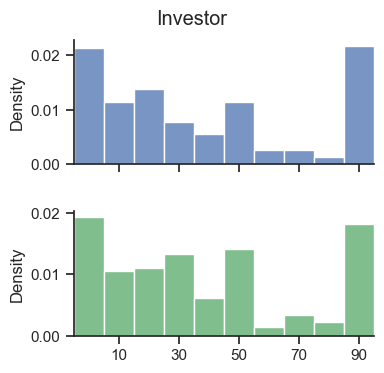

Smoothed Kolmogorov-Smirnov p-value: 0.03
======= Evaluating model prompts_Banker_weights_20241119171541...
Plotting Banker
Wasserstein Distance (rescaled): 1.52
Ranksums p-value: 0.26
Kolmogorov-Smirnov p-value: 0.02


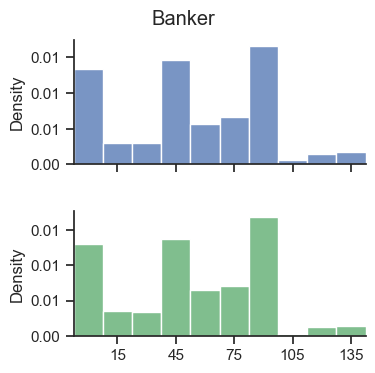

Smoothed Kolmogorov-Smirnov p-value: 0.15
======= Evaluating model prompts_Public Goods_weights_20241119171548...
Plotting Public Goods
Wasserstein Distance (rescaled): 2.27
Ranksums p-value: 0.05
Kolmogorov-Smirnov p-value: 0.04


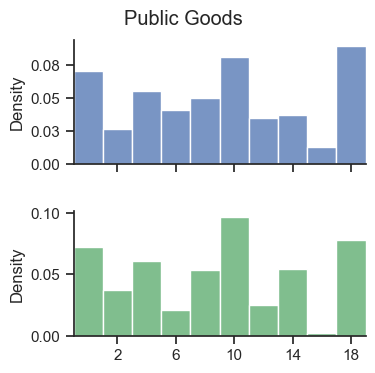

Smoothed Kolmogorov-Smirnov p-value: 0.07
======= Evaluating model prompts_Bomb_weights_20241119171614...
Plotting Bomb
Wasserstein Distance (rescaled): 4.78
Ranksums p-value: 0.01
Kolmogorov-Smirnov p-value: 0.00


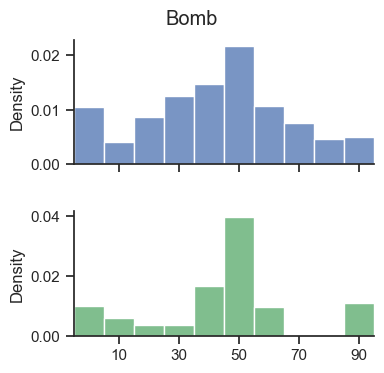

Smoothed Kolmogorov-Smirnov p-value: 0.00


In [26]:
print(len(df_joint))
for model, game2generated in model2generated.items():
    print(f'======= Evaluating model {model}...')
    evaluate(
        game2generated, 
        need_plot=True, 
        smooth_bin_width=10,
    )